In [1]:
import pgmpy
import math
import random
import string

import numpy as np
from gmr import GMM
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.metrics import log_likelihood_score
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, K2Score

%matplotlib inline
import bamt.Networks as Nets
import bamt.Preprocessors as pp
import networkx as nx

from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
def generate_random_dag(n, p):
    # генерируем случайное дерево
    edges = []
    for i in range(1, n):
        parent = random.randint(0, i - 1)
        edges.append((parent, i))

    # добавляем случайные ребра, пока не получим DAG
    while True:
        new_edge = (random.randint(0, n-1), random.randint(0, n-1))
        #if new_edge[0] >= new_edge[1]:
            #continue  # не добавляем обратное ребро
        if new_edge in edges:
            continue  # не добавляем дубликат ребра
        edges.append(new_edge)
        if is_dag(n, edges): # and len(edges) > int(n*1.5):
            if n > 4:
                if len(edges) >= int(n*(1+random.random())):
                    break
            else:
                break
        else:
            edges.remove(new_edge)
    return edges

def is_dag(n, edges):
    G = nx.DiGraph(edges)
    return nx.is_directed_acyclic_graph(G)

In [3]:
def generate_samples(k_samples=2, n_components=random.randint(1, 4)):
    """
    Случайная смесь Гауссовских распределений
    """

    # Генерация случайных значений для means
    means = np.random.uniform(low=-1, high=1, size=n_components)

    # Генерация случайных значений для covs
    covs = np.random.uniform(low=0, high=1, size=n_components)

    # Генерация случайных значений для weights
    weights = np.random.dirichlet(np.ones(n_components), size=1)[0]

    # Создание и обучение модели смеси гауссиан
    from sklearn.mixture import GaussianMixture

    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.means_ = means.reshape(-1, 1)  # преобразование вектора средних значений в столбец
    gmm.covariances_ = np.square(covs).reshape(-1, 1, 1)  # преобразование вектора дисперсий в матрицы ковариации
    gmm.weights_ = weights
    
    X = np.random.random(10**6)
    gmm.fit(X.reshape([-1, 1]))

    # Генерация случайной выборки из смеси гауссовских распределений
    y = gmm.sample(n_samples=10**k_samples) #10^6

    print(f'количество компонентов в смеси: {n_components}')
#     print(f'средние значения гауссовских распределений: {means}')
#     print(f'Ковариации: {covs}')
#     print(f'Веса: {weights}')

#     Визуализация сгенерированной выборки
#     import matplotlib.pyplot as plt

#     plt.hist(X, bins=20)
#     plt.show()
    
    return y[0]

In [4]:
def linear_func(x, k_samples=2):
    
    x = np.array(x)
    a = [random.random()*2-1 for i in x]
    b = [random.random()*2-1 for i in x]
    noise = np.array([np.random.normal(loc=0, scale = 1) for x in range(10**k_samples)]) / 100

    res = sum([a[i]*x[:,i] + b[i] for i in range(x.shape[1])]) + noise
    return res

In [5]:
def init_edges(edges):
    final = [0]*len(edges)
    for ind, edge in enumerate(edges):
        final[ind] = (str(edge[0]) + '_', str(edge[1]) + '_')
    return final

In [6]:
def create_dag(n_nodes, p):
    edges = generate_random_dag(n_nodes, p)
#     print(len(edges))
    G = nx.DiGraph(edges)
    assert nx.is_directed_acyclic_graph(G)
    return G, edges

In [7]:
def create_dataset(edges, X, k_samples=2):
    connections_to = {}
    connections_from ={}
    edges.sort()
    for ind, edge in enumerate(edges):
        connections_from[ind] = [edges[x][1] for x in range(len(edges)) if edges[x][0]==ind]
        connections_to[ind] = [edges[x][0] for x in range(len(edges)) if edges[x][1]==ind]
    
    df = pd.DataFrame(X, columns=[str(edges[0][0])])
    remaining_nodes = np.arange(1, n_nodes)
    for i in connections_from[0]:
        if len(connections_to[i]) == 1:
            x = (df[['0']])
            temp_df = pd.DataFrame(linear_func(x, k_samples), columns=[str(i)])
            df = pd.concat([df, temp_df], axis=1)
            remaining_nodes = np.delete(remaining_nodes, np.where(remaining_nodes==i))


    ind = 0
#     print(remaining_nodes)
    while len(remaining_nodes) > 0:
        k = remaining_nodes[ind]
        last_nodes = df.columns
        if len([x for x in connections_to[k] if str(x) in last_nodes]) == len(connections_to[k]):
#             print(str(k))
            x = np.array([0.0]*10**k_samples) #**6
#             print(connections_to[k])
            x = df[list(map(str, connections_to[k]))]
            temp_df = pd.DataFrame(linear_func(x, k_samples), columns=[str(k)])
            df = pd.concat([df, temp_df], axis=1)
            remaining_nodes = np.delete(remaining_nodes, np.where(remaining_nodes==k))
#             print(k)
        else:
            ind += 1
        if ind >= len(remaining_nodes):
            ind = 0
    
    return df

In [8]:
def desc_data(values, columns):
    disc_model = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    disc_model.fit(values)
    sample_disc = pd.DataFrame(disc_model.transform(values), columns=columns)

    return sample_disc

In [9]:
def create_delts(Score_init, samping_model, test, k_samples=2):
    delts = []
    start = 4
    end = 10**k_samples
    step = 100
    for size in range(start, end, step):
        train = samping_model.forward_sample(size)
        est = HillClimbSearch(train)
        G_sample = BayesianNetwork(est.estimate(scoring_method=K2Score(train)))
        G_sample.fit(data=train,estimator=MaximumLikelihoodEstimator)
        score_sample = 0
        try:
            score_sample = log_likelihood_score(G_sample, test)  
#             print(f'size = {size}')
#             print(score_sample)
        except:
            score_sample = -1*np.inf
        delta = (round(Score_init - score_sample, 3))
        print(size)
        print(delta)
        delts.append(delta)
    
    return delts, G_sample
    

In [10]:
def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal=4):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'AP': round(corr_undir/pred_len, decimal),
            'AR': round(corr_undir/true_len, decimal),
            'F1_undir':round(2*(corr_undir/pred_len)*(corr_undir/true_len)/(corr_undir/pred_len+corr_undir/true_len), decimal),
            'AHP': round(corr_dir/pred_len, decimal),
            'AHR': round(corr_dir/true_len, decimal),
#            'F1_directed': round(2*(corr_dir/pred_len)*(corr_dir/true_len)/(corr_dir/pred_len+corr_dir/true_len), decimal),
            'SHD': shd}

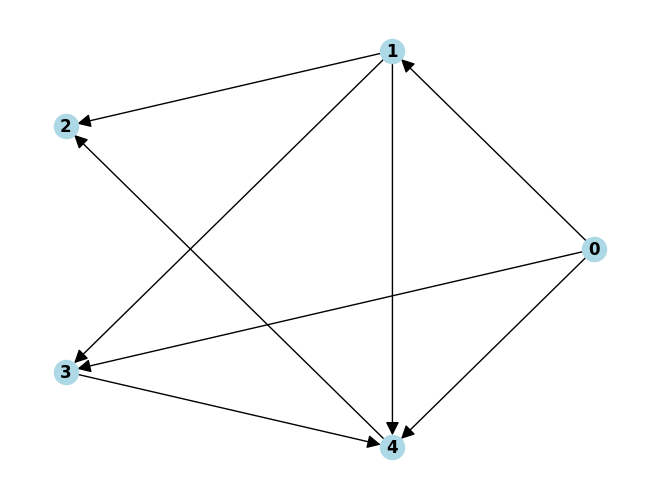

In [11]:
p = 0.5
n_nodes = 5
k_samples = 5

G, edges = create_dag(n_nodes, p)

# создаем графическое представление
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold', font_size=12, arrowsize=20)

plt.show()

количество компонентов в смеси: 3


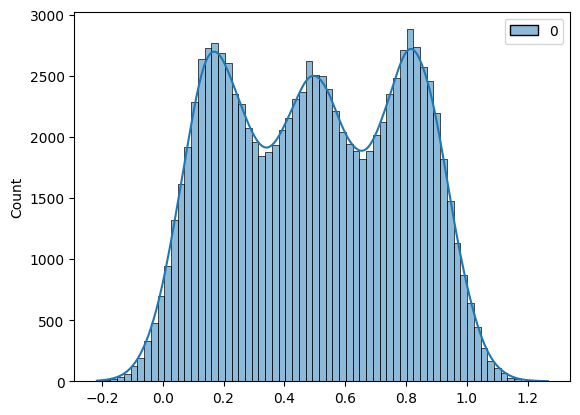

In [12]:
X = generate_samples(k_samples=5, n_components=3)
sns.histplot(X, kde=True)
plt.show()

In [13]:
df = create_dataset(edges, k_samples=5, X=X)

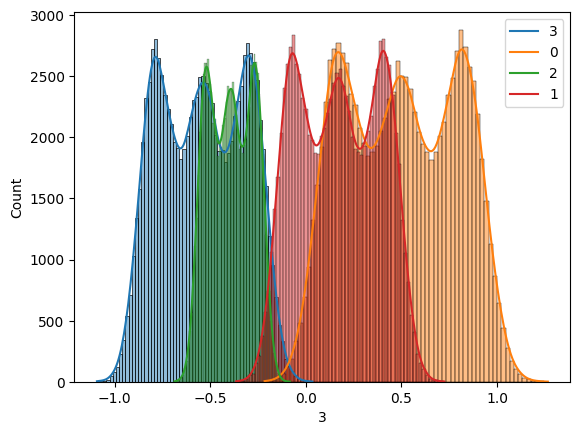

In [14]:
sns.histplot(df['3'], kde=True)
sns.histplot(df['0'], kde=True)
sns.histplot(df['2'], kde=True)
sns.histplot(df['1'], kde=True)
plt.legend(['3', '0', '2', '1'])

In [15]:
df.columns = [f'{x}_' for x in range(5)]

In [16]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(df)

2023-06-08 17:29:04,039 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [19]:
bn_2 = Nets.ContinuousBN(use_mixture=True)
d = p.info
bn_2.add_nodes(d)
params = {'init_nodes': ['0_', '1_', '2_', '3_', '4_'],
         'init_edges': init_edges(edges)}
bn_2.add_edges(discretized_data, scoring_function=('K2',K2Score), params=params)

In [20]:
bn_2.set_classifiers(classifiers={'0_':GMM(2)})

2023-06-08 17:30:56,568 | ERROR    | Networks.py-set_classifiers-0324 | Logit nodes are forbidden.


In [21]:
# Now let's plot graph
bn_2.plot('Simple.html')

In [22]:
bn_2.get_info()

,name,node_type,data_type,parents,parents_types
0,0_,MixtureGaussian,cont,[],[]
1,1_,MixtureGaussian,cont,[0_],[cont]
2,2_,MixtureGaussian,cont,"[1_, 4_]","[cont, cont]"
3,3_,MixtureGaussian,cont,"[0_, 1_]","[cont, cont]"
4,4_,MixtureGaussian,cont,"[0_, 1_, 3_]","[cont, cont, cont]"


In [23]:
k=5

In [24]:
bn_2.fit_parameters(df)

In [25]:
synth_data_k2 = bn_2.sample(10**k, as_df=True)

In [26]:
synth_data_k2

,0_,1_,3_,4_,2_
0,0.401535,0.111042,-0.620873,-0.422079,-0.603911
1,0.714741,0.336067,-1.031532,-0.308248,-0.366315
2,0.706733,0.315284,-0.999884,-0.320021,-0.386517
3,0.815192,0.398591,-1.149929,-0.249137,-0.302753
4,0.513609,0.175372,-0.748826,-0.391263,-0.546116
...,...,...,...,...,...
99995,0.925243,0.481474,-1.279299,-0.204630,-0.219919
99996,0.724190,0.332770,-1.034334,-0.295140,-0.374152
99997,0.573510,0.229148,-0.857349,-0.364135,-0.479694
99998,0.496112,0.168160,-0.747453,-0.390278,-0.556807


<AxesSubplot:xlabel='0_', ylabel='Count'>

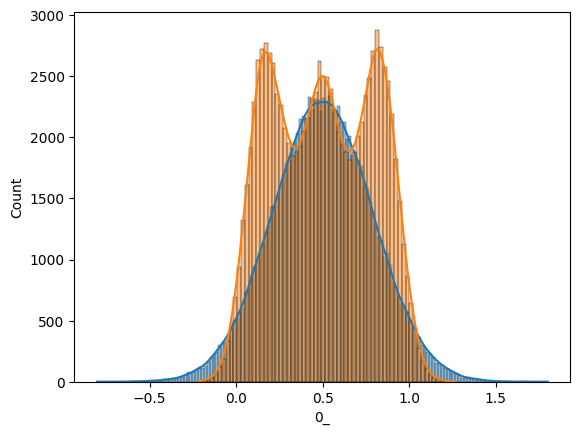

In [31]:
sns.histplot(synth_data_k2['0_'], kde=True)
sns.histplot(df['0_'], kde=True)

<AxesSubplot:xlabel='3_', ylabel='Count'>

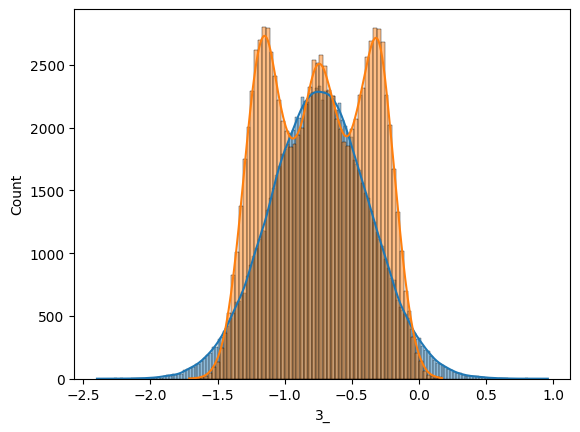

In [28]:
sns.histplot(synth_data_k2['3_'], kde=True)
sns.histplot(df['3_'], kde=True)

<AxesSubplot:xlabel='4_', ylabel='Count'>

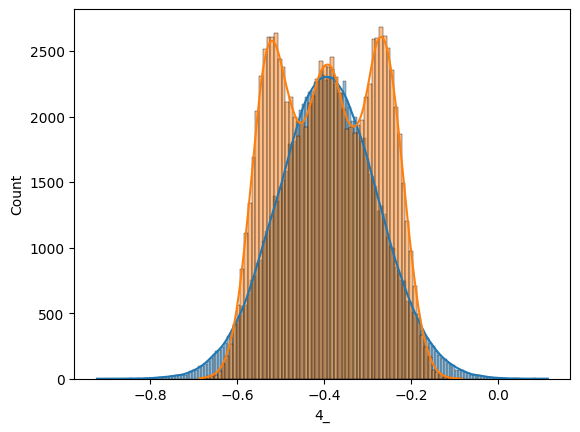

In [29]:
sns.histplot(synth_data_k2['4_'], kde=True)
sns.histplot(df['4_'].sample(10**k), kde=True)

In [30]:
synth_data_k2

,0_,1_,3_,4_,2_
0,0.401535,0.111042,-0.620873,-0.422079,-0.603911
1,0.714741,0.336067,-1.031532,-0.308248,-0.366315
2,0.706733,0.315284,-0.999884,-0.320021,-0.386517
3,0.815192,0.398591,-1.149929,-0.249137,-0.302753
4,0.513609,0.175372,-0.748826,-0.391263,-0.546116
...,...,...,...,...,...
99995,0.925243,0.481474,-1.279299,-0.204630,-0.219919
99996,0.724190,0.332770,-1.034334,-0.295140,-0.374152
99997,0.573510,0.229148,-0.857349,-0.364135,-0.479694
99998,0.496112,0.168160,-0.747453,-0.390278,-0.556807


In [32]:
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
model = get_example_model('alarm')
# Generate some new data.
data = BayesianModelSampling(model).forward_sample(int(1e3))

  0%|          | 0/37 [00:00<?, ?it/s]